<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/Download_Datasets_nc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade xee

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.7 MB/s eta 0:00:00


In [3]:
!pip install --upgrade geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00


In [4]:
!pip install --upgrade netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.9 MB/s eta 0:00:00


In [5]:
import ee
import os
import geemap
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
geemap.ee_initialize()
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com', project='ee-xxxxxxxxxxxx')

In [19]:
#LEER .nc DEL AREA DE ESTUDIO
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis"
area_estudio = xr.open_dataset(os.path.join(path, "NetCDF_CM/Poligonos_int.nc"))
area_estudio

<xarray.Dataset> Size: 84MB
Dimensions:  (lat: 1133, lon: 1233)
Coordinates:
  * lat      (lat) float64 9kB 20.19 20.19 20.19 20.19 ... 19.06 19.06 19.06
  * lon      (lon) float64 10kB -99.43 -99.43 -99.43 ... -98.2 -98.2 -98.2
Data variables:
    CM       (lat, lon) int32 6MB ...
    1507     (lat, lon) int64 11MB ...
    1319     (lat, lon) int64 11MB ...
    0901     (lat, lon) int64 11MB ...
    1320     (lat, lon) int64 11MB ...
    2902     (lat, lon) int64 11MB ...
    1506     (lat, lon) int64 11MB ...
    1508     (lat, lon) int64 11MB ...

In [9]:
#LEER DATASET DE EARTH ENGINE (CHIRPS)
start = '2001-01-01'
end   = '2021-12-31'
geometry = ee.Geometry.BBox(-99.466, 19, -98.133, 20.233)     #lon,lat del area rectangular que abarca el area de estudio
chirps_ee = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterDate(start, end)
chirps = xr.open_dataset(chirps_ee, engine='ee', geometry=geometry, scale=0.025, fast_time_slicing=True) #chirps = geemap.ee_to_xarray(chirps_ee) despliega todas las coordenadas
chirps = chirps.transpose("time", "lat","lon" )
chirps

<xarray.Dataset> Size: 80MB
Dimensions:        (time: 7669, lon: 53, lat: 49)
Coordinates:
  * time           (time) datetime64[ns] 61kB 2001-01-01 ... 2021-12-30
  * lon            (lon) float64 424B -99.45 -99.43 -99.4 ... -98.18 -98.15
  * lat            (lat) float64 392B 19.01 19.04 19.06 ... 20.16 20.19 20.21
Data variables:
    precipitation  (time, lat, lon) float32 80MB ...
Attributes: (12/20)
    date_range:               [347155200000, 1646006400000]
    description:              <p>Climate Hazards Group InfraRed Precipitation...
    keywords:                 ['chg', 'climate', 'geophysical', 'precipitatio...
    period:                   1
    period_mapping:           [347155200000, 1646006400000]
    product_tags:             ['precipitation', 'climate', 'weather', 'geophy...
    ...                       ...
    visualization_0_bands:    precipitation
    visualization_0_max:      17.0
    visualization_0_min:      1.0
    visualization_0_name:     Precipitation
    visualization_0_palette:  001137,0aab1e,e7eb05,ff4a2d,e90000
    crs:                      EPSG:4326

In [10]:
# Verificar los valores máximos y mínimos de una fecha
first_image = chirps["precipitation"].isel(time=6330) # time:'2018-05-02'
print(first_image.min().values, first_image.max().values)

0.0 17.65833854675293


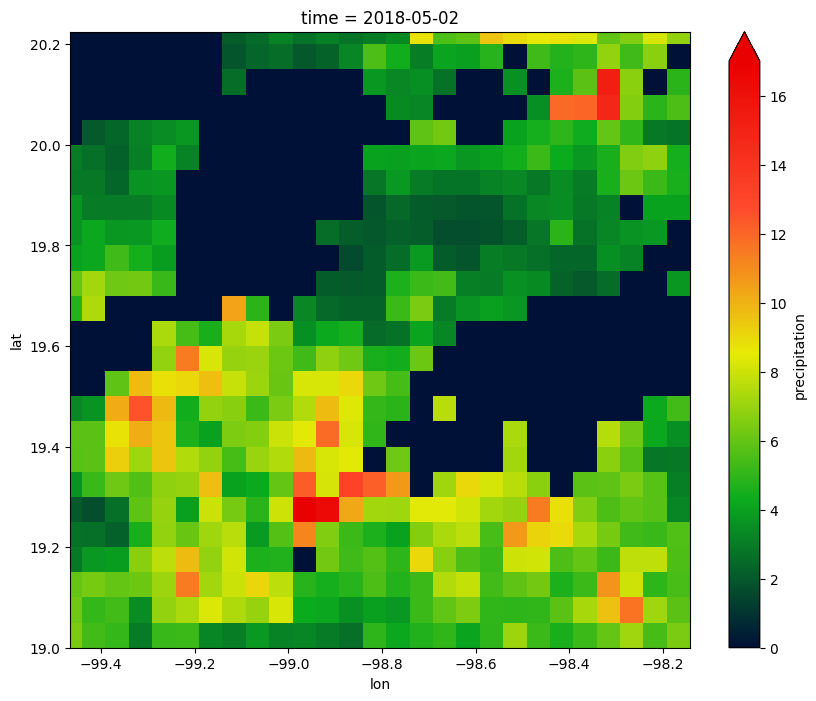

In [11]:
#VISUALIZAR LA IMAGEN DE UNA FECHA
# Paleta de colores
colors = ['#001137', '#0aab1e', '#e7eb05', '#ff4a2d', '#e90000']
cmap = mcolors.LinearSegmentedColormap.from_list('continuous_palette', colors)
first_image.plot(figsize=(10, 8), cmap=cmap, vmin=0, vmax=17)
# Muestra el gráfico
plt.show()

In [34]:
#RECORTAR EL DATASET EN EL AREA DE ESTUDIO
mascara_cm = area_estudio['CM']  # Reemplazar 'CM' si se desea recortar con otro poligono dentro del area de estudio
mascara_cm = mascara_cm.interp_like(chirps, method='nearest')
# Aplicar la máscara al dataset
dataset_cm = chirps.where(mascara_cm == 1)
# Guardar .nc
output_path = os.path.join(path, "NetCDF_CM/CHIRPS_Daily_CM.nc")
dataset_cm.to_netcdf(output_path, engine="netcdf4")

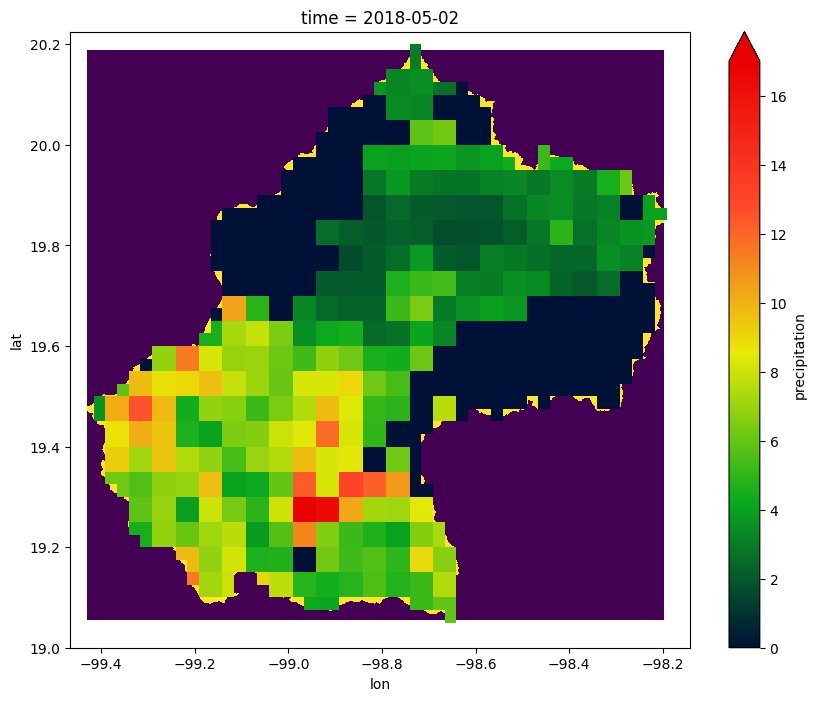

In [33]:
# Visualizar la imagen
image = dataset_cm["precipitation"].isel(time=6330) # time:'2018-05-02'
# Paleta de colores de precipitacion
colors = ['#001137', '#0aab1e', '#e7eb05', '#ff4a2d', '#e90000']
cmap = mcolors.LinearSegmentedColormap.from_list('continuous_palette', colors)

fig, ax = plt.subplots(figsize=(10, 8))
area =area_estudio['CM']
area.plot(ax=ax, add_colorbar=False)
image.plot(ax=ax, cmap=cmap, vmin=0, vmax=17)
plt.show()